# 03.Transformer：模型的计算引擎

在 2017 年那篇著名的论文《Attention is All You Need》横空出世之前，深度学习处理语言主要依靠 **RNN（循环神经网络）**。RNN 的逻辑非常符合人类直觉——像读书一样，逐字扫描。但这种“线性思维”存在两个致命缺陷：一是**慢**（无法并行计算），二是**健忘**（处理长句时，开头的语义会逐渐消失）。

Transformer 的出现，彻底打破了这种线性的枷锁。它抛弃了循环结构，改用 **Self-Attention（自注意力机制）**。

### 1. RNN 在干什么

RNN 的核心思想很简单:**按时间顺序，一个一个地处理 token**
这意味着,当前 token 的理解，依赖上一个隐藏状态,信息通过“状态”往后传递。但也因此产生了几个问题。

**问题 1：无法并行**
token 必须一个接一个算,GPU 利用率极低，长文本直接拖垮性能。

**问题 2：长期依赖困难**

例如：“我昨天在北京见到的那个穿红色外套、戴眼镜、说话很快的人，其实是……”
这里关键信息在开头，判断在结尾，中间跨度极长。

RNN 需要把“北京”“那个人”一直记住，这在现实中几乎不可能

**问题 3：信息会退化**

信息通过一个隐藏状态压缩传递，越往后，越模糊，本质上是“信息瓶颈”

#### Transformer的出现

**Transformer**的出现，彻底打破了这种线性的枷锁。它抛弃了循环结构，改用 **Self-Attention（自注意力机制）**。

举个人类的例子来说：当人理解“我把书放在桌子上，因为它太小了。”这句话时自动问：“它”指的是书，还是桌子？

然后回看上下文，重新分配注意力。

Transformer中的Attention就是**动态分配关注点**。

这意味着：

1. 模型不再逐字扫描，而是一瞬间“看”完整个句子。
2. 无论两个词距离多远，自注意力机制都能计算它们之间的语义关联。
3. 由于不再依赖前一个词的计算结果，Transformer 可以在现代 GPU 上进行大规模并行训练，这直接开启了“大”模型时代。

Transformer的架构如下:

![transformer](./raw/transformer.png)

简单来说它由一个编码器和一个解码器组成。
- 编码器负责将输入序列转换为一系列隐藏表示，捕获输入序列的信息并传递给解码器。
- 解码器接收编码器的输出和先前的解码器输出，生成序列的目标语言表示。
简化的处理流程如下：

![transformer_encoder](./raw/transformer_encoder.gif)

![transformer_decoder](./raw/transformer_decoder.gif)

**Transformer的核心**：

1. **注意力机制 (Self-Attention)**：解析模型如何学会在海量信息中“划重点”。
2. **多头设计 (Multi-Head Attention)**：理解模型如何同时从不同维度（语法、情感、逻辑）观察同一个词。
3. **位置编码 (Positional Encoding)**：在失去序列顺序后，模型如何找回文字的“前后位置感”。
4. **编码器与解码器 (Encoder & Decoder)**：探索理解（理解输入）与创造（预测输出）的结构分工。



## 二、Self-Attention 在“算什么”？
Self-Attention 的本质，并不是“理解语言”，而是*为序列中的每一个 Token，计算它应该“关注”其他 Token 的权重，然后按权重做加权求和。**

具体来说，对序列中的每个 Token，模型都会生成三样东西：

* **Q（Query，查询）**：我在找什么？
* **K（Key，键）**：我是谁？我能被如何匹配？
* **V（Value，值）**：如果你关注我，你能从我这里拿走什么信息？

注意力的核心公式是：

```text
Attention(Q, K, V) = softmax(Q · Kᵀ / √d) · V
```

它在做三件事：

1. **相似度计算**：
   用点积 `Q · Kᵀ` 衡量 Token 之间的相关性
2. **归一化权重**：
   用 `softmax` 把相关性变成“注意力分布”
3. **信息聚合**：
   用权重对所有 `V` 做加权求和，得到新的表示


### 实战：手写一个简易 Self-Attention

In [1]:
import torch
import seaborn as sns

import platform
import matplotlib.pyplot as plt

system = platform.system()
if system == "Windows":
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
elif system == "Darwin":  # macOS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
else:  # Linux (如 Ubuntu)
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']

plt.rcParams['axes.unicode_minus'] = False

# 一个非常短的句子
tokens = ["我", "把", "书", "放在", "桌子", "上"]

n_tokens = len(tokens)

In [2]:
# 构造Embedding

torch.manual_seed(42)

# 假设 embedding 维度 = 4
d_model = 4

embeddings = torch.randn(n_tokens, d_model)
embeddings

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055],
        [ 0.6784, -1.2345, -0.0431, -1.6047],
        [ 0.3559, -0.6866, -0.4934,  0.2415],
        [-1.1109,  0.0915, -2.3169, -0.2168],
        [-0.3097, -0.3957,  0.8034, -0.6216],
        [-0.5920, -0.0631, -0.8286,  0.3309]])

In [3]:
# 随机初始化线性映射 生成 Q / K / V
W_Q = torch.randn(d_model, d_model)
W_K = torch.randn(d_model, d_model)
W_V = torch.randn(d_model, d_model)

Q = embeddings @ W_Q
K = embeddings @ W_K
V = embeddings @ W_V

Q, K, V

(tensor([[-1.7405,  3.3628,  4.3763,  2.5923],
         [-3.4272,  0.0281,  4.6347,  1.8314],
         [ 0.0957, -0.9046,  0.9484, -1.4858],
         [ 3.1113, -2.2762, -1.6629, -4.0662],
         [-2.4022,  0.6188,  0.8455,  3.0231],
         [ 1.4616, -1.1198, -1.3630, -1.7808]]),
 tensor([[-4.6247, -2.0605,  5.5346,  1.7538],
         [-2.8556, -1.7733,  0.2916,  1.8747],
         [ 0.3270, -0.6624,  0.1150, -0.0874],
         [ 3.4947, -0.7209,  0.7055, -1.2929],
         [-1.5827,  0.4361, -1.6921,  1.0368],
         [ 1.8576,  0.1342, -0.4181, -0.7661]]),
 tensor([[ 4.2962, -3.1564,  3.5323, -0.3516],
         [ 0.6399, -0.1413,  1.9496, -4.5137],
         [-1.6082,  0.9454, -0.5397, -1.0974],
         [-6.5409, -1.4240,  0.5480, -1.0593],
         [ 2.4887,  0.0136,  0.7045, -1.1508],
         [-2.6168, -0.0132, -0.4382,  0.0714]]))

In [4]:
# 计算 Attention Scores
scores = Q @ K.T
scores

tensor([[ 29.8873,   5.1431,  -2.5200,  -8.7709,  -0.4961,  -6.5974],
        [ 44.6547,  14.5218,  -0.7665, -11.0953,  -0.5072,  -9.7033],
        [  4.0649,  -1.1779,   0.8693,   3.5767,  -3.6912,   0.7982],
        [-26.0332, -12.9563,   2.6892,  16.5982,  -7.3190,   9.2846],
        [ 19.8156,  11.6765,  -1.3623, -12.1533,   5.7755,  -7.0489],
        [-15.1187,  -5.9240,   1.2186,   7.2560,  -2.3417,   4.4989]])

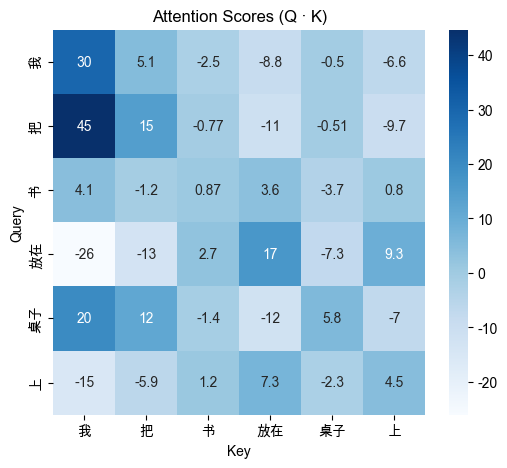

In [5]:
# Attention Score 可视化
plt.figure(figsize=(6, 5))
sns.heatmap(
    scores.detach().numpy(),
    xticklabels=tokens,
    yticklabels=tokens,
    annot=True,
    cmap="Blues"
)
plt.title("Attention Scores (Q · K)")
plt.xlabel("Key")
plt.ylabel("Query")
plt.show()

In [6]:
# Attention Weights
attn_weights = torch.softmax(scores, dim=-1)
attn_weights

tensor([[1.0000e+00, 1.7936e-11, 8.4270e-15, 1.6253e-17, 6.3775e-14, 1.4285e-16],
        [1.0000e+00, 8.1933e-14, 1.8786e-20, 6.1392e-25, 2.4348e-20, 2.4698e-24],
        [5.8876e-01, 3.1117e-03, 2.4105e-02, 3.6132e-01, 2.5204e-04, 2.2449e-02],
        [3.0561e-19, 1.4601e-13, 9.1021e-07, 9.9933e-01, 4.0985e-11, 6.6598e-04],
        [9.9971e-01, 2.9183e-04, 6.3448e-10, 1.3061e-14, 7.9863e-07, 2.1517e-12],
        [1.7992e-10, 1.7712e-06, 2.2400e-03, 9.3814e-01, 6.3686e-05, 5.9551e-02]])

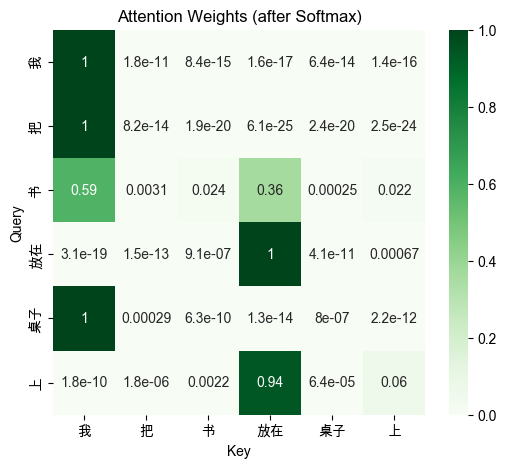

In [7]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    attn_weights.detach().numpy(),
    xticklabels=tokens,
    yticklabels=tokens,
    annot=True,
    cmap="Greens"
)
plt.title("Attention Weights (after Softmax)")
plt.xlabel("Key")
plt.ylabel("Query")
plt.show()

In [8]:
# 计算 Attention Output
output = attn_weights @ V
output

tensor([[ 4.2962, -3.1564,  3.5323, -0.3516],
        [ 4.2962, -3.1564,  3.5323, -0.3516],
        [ 0.0711, -2.3509,  2.2611, -0.6290],
        [-6.5383, -1.4231,  0.5473, -1.0585],
        [ 4.2952, -3.1556,  3.5318, -0.3529],
        [-6.2956, -1.3346,  0.4868, -0.9920]])

以上就是一次完整的 Self-Attention：

1. embedding → Q / K / V
2. Q · K → 相关性
3. softmax → 注意力分布
4. 加权求和 V → 新 token 表示

## 三.Layer 在模型中承担的角色

一个标准 Transformer 通常包含以下几层：

1. **Self-Attention**:让 Token 融合上下文信息
2. **Feed-Forward Network（FFN）**:对每个 Token 独立做非线性变换
3. **Residual + LayerNorm**:稳定训练，防止信息退化


### 实战：一层在“改变什么”？

下面用一个极简示例，展示**同一输入经过一层前后的变化**。

In [ ]:
import numpy as np

np.set_printoptions(precision=3, suppress=True)

# 假设有 3 个 token，每个 token 是 4 维向量
X = np.array([
    [1.0, 0.0, 1.0, 0.0],
    [0.0, 2.0, 0.0, 2.0],
    [1.0, 1.0, 1.0, 1.0],
])

# ---- Self-Attention（简化版）----
def self_attention(X):
    W = np.random.rand(X.shape[1], X.shape[1])
    Q = X @ W
    K = X @ W
    V = X @ W

    scores = Q @ K.T / np.sqrt(X.shape[1])
    weights = np.exp(scores) / np.exp(scores).sum(axis=-1, keepdims=True)
    return weights @ V

# ---- Feed Forward Network ----
def feed_forward(X):
    W1 = np.random.rand(X.shape[1], X.shape[1] * 2)
    W2 = np.random.rand(X.shape[1] * 2, X.shape[1])
    return np.maximum(0, X @ W1) @ W2  # ReLU

# ---- Layer 组合 ----
def transformer_layer(X):
    attn_out = self_attention(X)
    X = X + attn_out          # Residual
    X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-6)

    ffn_out = feed_forward(X)
    X = X + ffn_out           # Residual
    X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-6)
    return X

# 执行一层
output = transformer_layer(X)

print("输入表示：\n", X)
print("\n经过一层后的表示：\n", output)


从结果可以清楚地看到，输入与输出在维度和 Token 数量上完全一致，但向量的数值分布已经发生了显著变化。这说明这一层并没有“记住原样”，而是通过 Self-Attention 将每个 Token 与上下文重新关联，再通过前馈网络进行非线性重映射，使得每个 Token 的表示都变成了**“结合了全局上下文的新身份”**。

同时，由于归一化的存在，输出向量呈现出正负分布、均值接近零的特征，这表明模型在主动拉开不同维度的表达差异，避免信息塌缩。直观上看，每一行都已经不再对应某个“原始输入向量”，而是一个在当前层语义空间中重新定位后的点。